In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
import pandas as pd

In [2]:
import pyspark.sql.functions as F

In [3]:
lending = spark.read.csv('accepted_2007_to_2018Q4.csv.gz', inferSchema=True, header=True)
lending.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [14]:
lending.filter(lending.chargeoff_within_12_mths.isNull()).count()

432

# Cleaning and Tranforming Data

## Decide on categories for features


In [4]:
lending.select('loan_status').distinct().show(20, False) #shows different loan statuses

+---------------------------------------------------+
|loan_status                                        |
+---------------------------------------------------+
|Fully Paid                                         |
|Default                                            |
|null                                               |
|In Grace Period                                    |
|Does not meet the credit policy. Status:Fully Paid |
|Charged Off                                        |
|Oct-2015                                           |
|Late (31-120 days)                                 |
|Current                                            |
|Does not meet the credit policy. Status:Charged Off|
|Late (16-30 days)                                  |
+---------------------------------------------------+



Response variable is loan_status. Here we look at stats and change the loan status column so that "Default", "Charged Off", and "Does not meet the credit policy. Status:Charged Off" are all 1 (for default) and everything else is 0.

In [5]:
# Show counts of each loan status.. and percentage

lending_status = lending.select('loan_status')
total_rec = lending.count()
lending_stat_grp = lending_status.groupBy('loan_status').count()
lending_stat_grp = lending_stat_grp.withColumn('percentage', 
                                               F.round(lending_stat_grp['count']/total_rec * 100, 2))
#c = 'percentage'
lending_stat_grp.show(20,False) # I need to round this column but haven't figured that out yet also the 20



+---------------------------------------------------+-------+----------+
|loan_status                                        |count  |percentage|
+---------------------------------------------------+-------+----------+
|Fully Paid                                         |1076751|47.63     |
|Default                                            |40     |0.0       |
|null                                               |33     |0.0       |
|In Grace Period                                    |8436   |0.37      |
|Does not meet the credit policy. Status:Fully Paid |1988   |0.09      |
|Charged Off                                        |268558 |11.88     |
|Oct-2015                                           |1      |0.0       |
|Late (31-120 days)                                 |21467  |0.95      |
|Current                                            |878317 |38.85     |
|Does not meet the credit policy. Status:Charged Off|761    |0.03      |
|Late (16-30 days)                                 

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [12]:
statuses = lending_stat_grp.select("loan_status").rdd.flatMap(lambda x: x).collect()
statuses[2]="None" # since Plotting doesn't like None
status_counts =  lending_stat_grp.select("count").rdd.flatMap(lambda x: x).collect()

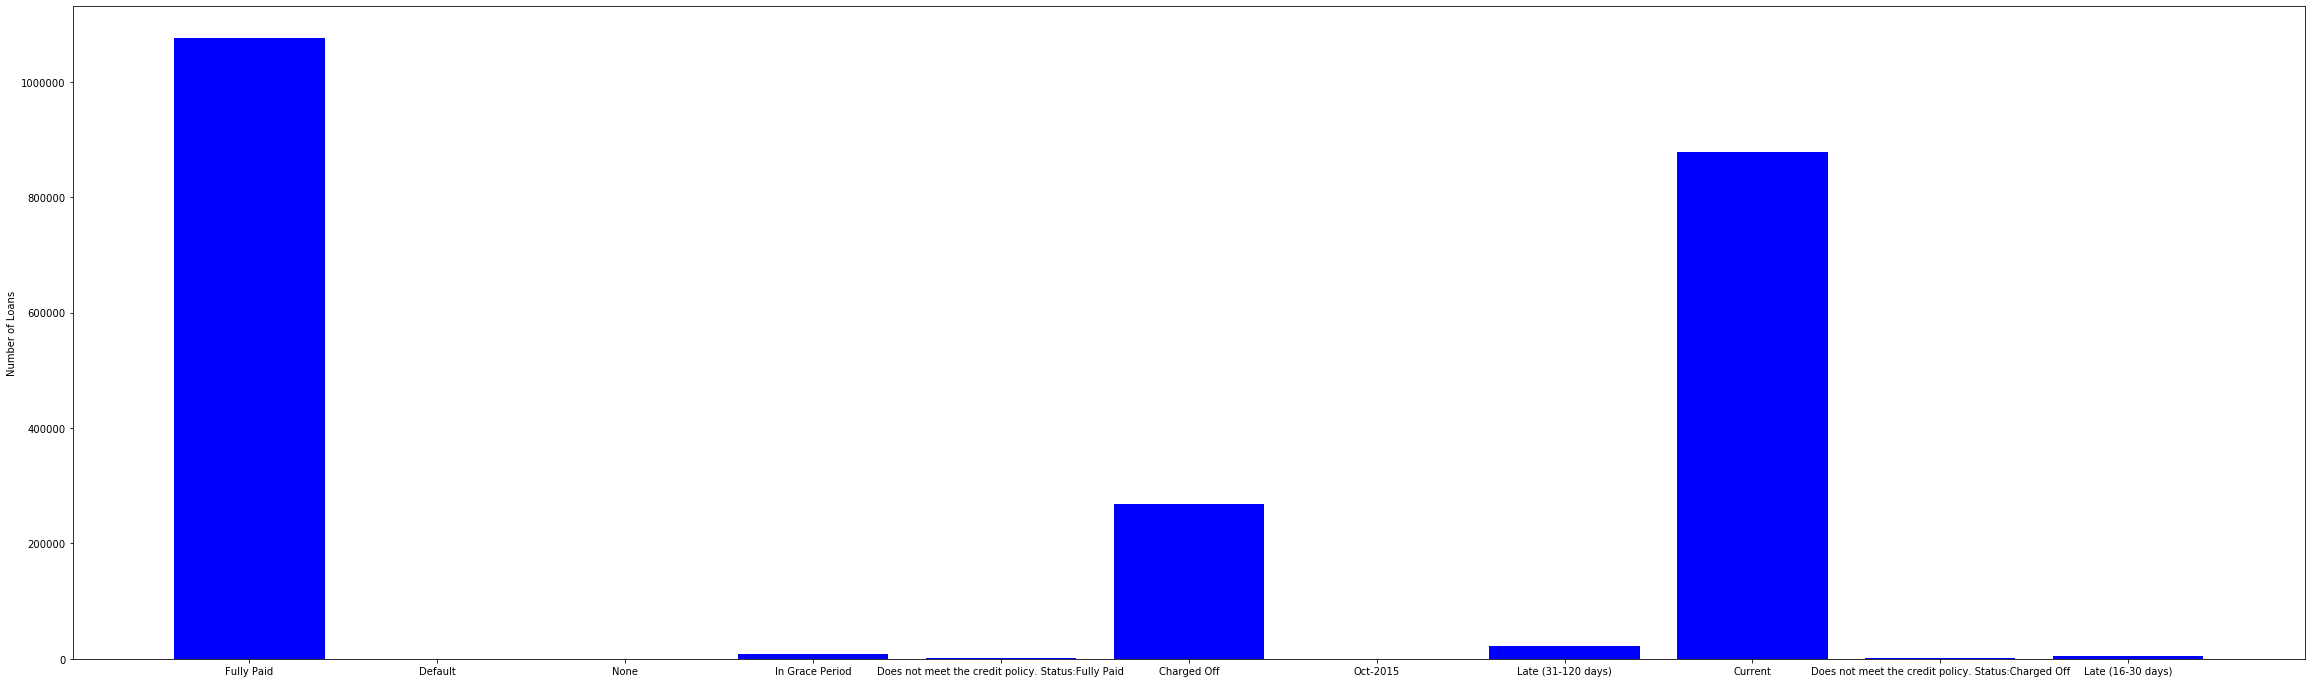

In [13]:
# Plotting Response Variable
plt.figure(figsize=(40,12))
plt.bar(statuses, status_counts, width=0.8, label='Loan Status', color='blue')
#plt.xticks(ind, labels)
plt.ylabel("Number of Loans")
plt.show()
#we can see the majority of our data set is current and fully paid. With Charged off being the 3rd largest

In [4]:
#making loan status binary 1: Default 0: Current
lending = lending.withColumn('loan_status_binary', F.when( (lending['loan_status'] == 'Default') | \
                                            (lending['loan_status'] == 'Charged Off') | \
                                            (lending['loan_status'] == 'Charged off and Does not meet the credit policy.'),1).otherwise(0))


In [5]:
lending.groupBy('loan_status_binary').count().show()

+------------------+-------+
|loan_status_binary|  count|
+------------------+-------+
|                 1| 268598|
|                 0|1992103|
+------------------+-------+



In [5]:
df = lending.select('loan_status_binary','loan_amnt', 'term', 'int_rate', 'grade', 'emp_length',
                          'home_ownership', 'tot_cur_bal', 'total_pymnt', 'annual_inc', 'addr_state', 
                             'fico_range_low', 'last_pymnt_amnt', 'debt_settlement_flag',\
                   'pub_rec_bankruptcies', 'delinq_2yrs', 'chargeoff_within_12_mths')

In [17]:
df.printSchema()

root
 |-- loan_status_binary: integer (nullable = false)
 |-- loan_amnt: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- tot_cur_bal: string (nullable = true)
 |-- total_pymnt: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- last_pymnt_amnt: string (nullable = true)
 |-- debt_settlement_flag: string (nullable = true)
 |-- pub_rec_bankruptcies: double (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- chargeoff_within_12_mths: double (nullable = true)



In [10]:
# for each field, compute missing percentage

df.agg(*[
    (1 - F.count(c) / F.count('*')).alias(c + '_miss')
    for c in df.columns
]).show()

+-----------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|loan_status_binary_miss|      loan_amnt_miss|           term_miss|       int_rate_miss|          grade_miss|    emp_length_miss| home_ownership_miss|    tot_cur_bal_miss|    total_pymnt_miss|     annual_inc_miss|     addr_state_miss| fico_range_low_miss|last_pymnt_amnt_miss|
+-----------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                    0.0|1.459724218288993...|1.459724218288993...|1.459724218288993...|1.459724218288993...|0.06499753837415911|1.459724218288993...|0.03105408455165015

In [11]:
df.take(3)

[Row(loan_status_binary=0, loan_amnt=3600.0, term=' 36 months', int_rate=13.99, grade='C', emp_length='10+ years', home_ownership='MORTGAGE', tot_cur_bal='144904.0', total_pymnt='4421.723916800001', annual_inc='55000.0', addr_state='PA', fico_range_low='675.0', last_pymnt_amnt='122.67'),
 Row(loan_status_binary=0, loan_amnt=24700.0, term=' 36 months', int_rate=11.99, grade='C', emp_length='10+ years', home_ownership='MORTGAGE', tot_cur_bal='204396.0', total_pymnt='25679.66', annual_inc='65000.0', addr_state='SD', fico_range_low='715.0', last_pymnt_amnt='926.35'),
 Row(loan_status_binary=0, loan_amnt=20000.0, term=' 60 months', int_rate=10.78, grade='B', emp_length='10+ years', home_ownership='MORTGAGE', tot_cur_bal='189699.0', total_pymnt='22705.924293878397', annual_inc='63000.0', addr_state='IL', fico_range_low='695.0', last_pymnt_amnt='15813.3')]

In [9]:
df.cache()

DataFrame[loan_status_binary: int, loan_amnt: double, term: string, int_rate: double, grade: string, emp_length: string, home_ownership: string, tot_cur_bal: string, total_pymnt: string, annual_inc: string, addr_state: string, fico_range_low: string, last_pymnt_amnt: string, debt_settlement_flag: string]

In [22]:
#Count different levels of term
df.groupBy('term').count().show()

+----------+-------+
|      term|  count|
+----------+-------+
| 36 months|1609754|
|      null|     33|
| 60 months| 650914|
+----------+-------+



In [6]:
#remove null rows
df = df.filter(df.term.isNotNull())
df = df.filter(df.chargeoff_within_12_mths.isNotNull())

In [8]:
# row count
print(f'rows={df.count()}')

rows=2260668


In [28]:
# distinct row count
print(f'rows={df.distinct().count()}')

rows=2260668


In [7]:
#Looks like there are duplicates so we will drop those
df = df.dropDuplicates()
print(f'rows={df.count()}')

rows=2260269


### Analyze Annual Income

In [16]:
#See if any rows of annual income contain non-numeric values
df.select('annual_inc').filter(df['annual_inc'].rlike('[A-Za-z]+')).show()

+----------+
|annual_inc|
+----------+
|  MORTGAGE|
+----------+



In [8]:
#Remove string row and convert column to float
df = df.filter(df['annual_inc'] != 'MORTGAGE')
df = df.withColumn('annual_inc', df['annual_inc'].cast('float'))

### Clean Up Other Columns

In [9]:
df = df.filter(df.pub_rec_bankruptcies.isNotNull())

In [22]:
df.groupBy('pub_rec_bankruptcies').count().show()

+--------------------+-------+
|pub_rec_bankruptcies|  count|
+--------------------+-------+
|                 8.0|     10|
|                 0.0|1987155|
|                 7.0|     23|
|                 1.0| 258426|
|                 4.0|    541|
|                11.0|      1|
|                 3.0|   2131|
|                 2.0|  10518|
|                 6.0|     60|
|                 5.0|    189|
|                 9.0|      3|
|                12.0|      1|
+--------------------+-------+



In [13]:
df.groupBy('delinq_2yrs').count().show()

+-----------+-------+
|delinq_2yrs|  count|
+-----------+-------+
|        1.0| 281201|
|       22.0|      5|
|       20.0|     17|
|       15.0|     87|
|       25.0|      2|
|       26.0|      3|
|       17.0|     30|
|        0.0|1837762|
|        9.0|    818|
|       12.0|    263|
|       18.0|     30|
|       10.0|    556|
|       29.0|      2|
|       14.0|    120|
|       19.0|     23|
|       23.0|      2|
|        5.0|   6598|
|        6.0|   3716|
|       35.0|      1|
|       32.0|      1|
+-----------+-------+
only showing top 20 rows



In [10]:
df = df.filter(df['delinq_2yrs'] != '049xx') #clean up this one row

In [11]:
#Convert these columns since they are numbers but cast as strings in original data
df = df.withColumn("tot_cur_bal", df['tot_cur_bal'].cast('float'))
df = df.withColumn("total_pymnt", df["total_pymnt"].cast('float'))
df = df.withColumn("fico_range_low", df["fico_range_low"].cast('float'))
df = df.withColumn("last_pymnt_amnt", df["last_pymnt_amnt"].cast('float'))
df = df.withColumn("delinq_2yrs", df["delinq_2yrs"].cast('float'))

In [19]:
#Descriptive stats on numerical columns
df.describe('loan_amnt', 'int_rate', 'tot_cur_bal', 'total_pymnt','last_pymnt_amnt',
           'annual_inc').show()

+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|         loan_amnt|          int_rate|      tot_cur_bal|       total_pymnt|   last_pymnt_amnt|        annual_inc|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|           2260663|           2260663|          2190483|           2260602|           2260596|           2260663|
|   mean|15046.948715929795| 13.09283936172734|142486.1040603191|12081.567740350712|3429.3736329090607| 77992.44637777765|
| stddev| 9190.247731503307|4.8321384083121925|160691.9677185479| 9901.817686563189| 6018.386982155955|112696.22136098208|
|    min|             500.0|              5.31|              0.0|               0.0|               0.0|               0.0|
|    max|           40000.0|             30.99|        9971659.0|          63296.88|          42192.05|             1.1E8|
+-------+-------

In [31]:
df.groupBy('addr_state').count().orderBy('count', ascending=False).show(66)

+--------------------+------+
|          addr_state| count|
+--------------------+------+
|                  CA|314481|
|                  NY|186370|
|                  TX|186318|
|                  FL|161977|
|                  IL| 91152|
|                  NJ| 83123|
|                  PA| 76930|
|                  OH| 75125|
|                  GA| 74186|
|                  VA| 62944|
|                  NC| 62730|
|                  MI| 58764|
|                  MD| 54000|
|                  AZ| 53769|
|                  MA| 51773|
|                  CO| 48178|
|                  WA| 47053|
|                  MN| 39513|
|                  IN| 37515|
|                  MO| 36082|
|                  CT| 35782|
|                  TN| 35483|
|                  NV| 32653|
|                  WI| 29873|
|                  SC| 28001|
|                  AL| 27282|
|                  OR| 26788|
|                  LA| 25757|
|                  KY| 21885|
|                  OK| 20691|
|         

It looks like there are some rows that aren't actually states, we'll need to get rid of those

In [12]:
#This uses a regex to find only state names on the 'addr_state' column
df= df.filter(df['addr_state'].rlike("^[A-Z]{2}$"))
#we can check that those rows have been removed
df.count()


2259057

In [12]:
df.groupBy('addr_state').count().orderBy('count', ascending=False).show(66)

+----------+------+
|addr_state| count|
+----------+------+
|        CA|314481|
|        NY|186370|
|        TX|186318|
|        FL|161977|
|        IL| 91152|
|        NJ| 83123|
|        PA| 76930|
|        OH| 75125|
|        GA| 74186|
|        VA| 62944|
|        NC| 62730|
|        MI| 58764|
|        MD| 54000|
|        AZ| 53769|
|        MA| 51773|
|        CO| 48178|
|        WA| 47053|
|        MN| 39513|
|        IN| 37515|
|        MO| 36082|
|        CT| 35782|
|        TN| 35483|
|        NV| 32653|
|        WI| 29873|
|        SC| 28001|
|        AL| 27282|
|        OR| 26788|
|        LA| 25757|
|        KY| 21885|
|        OK| 20691|
|        KS| 19106|
|        AR| 17074|
|        UT| 14990|
|        MS| 12638|
|        NM| 11985|
|        NH| 11140|
|        HI| 10667|
|        RI| 10004|
|        WV|  8350|
|        NE|  7819|
|        DE|  6456|
|        MT|  6298|
|        DC|  5355|
|        AK|  5229|
|        ME|  4973|
|        VT|  4937|
|        WY|  4747|


In [36]:
#Find Outliers

bnds = {}
cols = ['loan_amnt', 'int_rate', 'tot_cur_bal', 'fico_range_low', 'annual_inc']

def outliers(df):

    for col in cols:
        quantiles = df.approxQuantile(col, [0.25, 0.75], 0.05)
        IQR = quantiles[1] - quantiles[0]

        bnds[col] = [
         quantiles[0] - 1.5 * IQR,
         quantiles[1] + 1.5 * IQR
        ]
    return bnds

In [37]:
#Show Quantiles
outliers(df.select(cols))

{'loan_amnt': [-8600.0, 41000.0],
 'int_rate': [3.0250000000000004, 24.665],
 'tot_cur_bal': [-283352.5, 575859.5],
 'fico_range_low': [612.5, 792.5],
 'annual_inc': [-24605.0, 179563.0]}

We'll have to look into these negative numbers and clean them up, nobody actually got a negative balance

## Examine Grade

In [38]:
df.groupBy('grade').count().orderBy('count').show()

+-----+------+
|grade| count|
+-----+------+
|    G| 12163|
|    F| 41792|
|    E|135618|
|    D|324385|
|    A|432977|
|    C|650001|
|    B|663472|
+-----+------+



In [13]:
#remove null rows
df = df.filter(df.grade.isNotNull())

In [14]:
#Create dummy columns
## modified Grade_Feature to utilize one hot encoding
grade_feature = F.when(
    F.col("grade") == 'A', 'AB').when(F.col("grade") == 'B', 'AB').when(F.col("grade") == 'C', 'CD').when(F.col("grade") == 'D', 'CD').when(F.col("grade") == 'E', 'EFG').when(F.col("grade") == 'F', 'EFG').when(F.col("grade") == 'G', 'EFG').otherwise(0)
df = df.withColumn('grade_feature', grade_feature)
df = df.drop('grade')
print(df.filter(df['grade_feature']==0).count())


df.filter(df['tot_cur_bal'].isNull()).count() #70,018 records that are null.

0


68667

## Examine emp_length

In [26]:
df.groupBy('emp_length').count().orderBy('count').show()

+----------+------+
|emp_length| count|
+----------+------+
|   9 years| 79386|
|   8 years| 91911|
|   7 years| 92687|
|   6 years|102617|
|   4 years|136575|
|   5 years|139681|
|      null|146904|
|    1 year|148370|
|   3 years|180722|
|  < 1 year|189942|
|   2 years|203644|
| 10+ years|747969|
+----------+------+



In [15]:
#Create dummy columns

emp_length_low = F.when(
    F.col("emp_length") == '< 1 year', 1
).when(F.col("emp_length") == '2 years', 1
).when(F.col("emp_length") == '3 years', 1
).when(F.col("emp_length") == '4 years', 1
).when(F.col("emp_length") == '5 years', 1).otherwise(0)
df = df.withColumn('emp_length_low', emp_length_low)
df = df.drop('emp_length')

In [16]:
df = df.filter(df['loan_amnt'].isNotNull()) #This removes a row of all null values

### Fixing the Current Balance Column

In [33]:
data = df.filter(df['tot_cur_bal'].isNotNull())

from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml import Pipeline
#LinearRegression(featuresCol='features',
#labelCol='label', 
#predictionCol='prediction', maxIter=100, regParam=0.0, elasticNetParam=0.0, tol=1e-06, fitIntercept=True, standardization=True, solver='auto', weightCol=None, aggregationDepth=2, loss='squaredError', epsilon=1.35)[source]

In [34]:
train, test = data.randomSplit([0.8, 0.2], seed=12345)

#one hot encoding categorical variables
categories = ['home_ownership', 'term', 'grade_feature', 'emp_length_low']
stages = []
for col in categories:
    stringIndexer = StringIndexer(inputCol=col, outputCol=col + "_Index")
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(),
                            outputCol=col + "classVec")
    stages += [stringIndexer, encoder]

scaled_vectors = VectorAssembler(inputCols = ['loan_amnt',\
                                             'total_pymnt', 'annual_inc', \
                                             'fico_range_low', 'last_pymnt_amnt',\
                                             'int_rate','emp_length_low'], 
                                 outputCol='vector_features')

scaler = StandardScaler(inputCol='vector_features', outputCol='scaled_features')

assembler = VectorAssembler(inputCols=['scaled_features', 'home_ownershipclassVec', 'termclassVec'], outputCol='features')

stages += [scaled_vectors, scaler, assembler]

lr = LinearRegression(labelCol = 'tot_cur_bal', maxIter=10)

stages += [lr]

pipeline = Pipeline(stages = stages)

model = pipeline.fit(train)

prediction = model.transform(test)

In [35]:
type(prediction)
type(prediction.select(['prediction']))

pyspark.sql.dataframe.DataFrame

In [37]:
null_data = df.filter(df['tot_cur_bal'].isNull())
prediction_of_null = model.transform(null_data)

In [27]:
prediction_of_null.select(['tot_cur_bal', 'prediction']).show(10)

+-----------+-------------------+
|tot_cur_bal|         prediction|
+-----------+-------------------+
|       null| 18431.709886190383|
|       null|  7630.171391053754|
|       null|-2132.8470041299856|
|       null|  32036.48676806287|
|       null| 16744.407977163824|
|       null|  30804.57645842154|
|       null| 16964.616386140133|
|       null| -4195.699993295411|
|       null|  55251.18191716041|
|       null| 16211.932758853527|
+-----------+-------------------+
only showing top 10 rows



In [38]:
pandas_df = df.toPandas()
prediction_df = prediction_of_null.toPandas()
print(len(prediction_df['prediction']))
print(len(pandas_df[pandas_df.tot_cur_bal.isnull()]))
#this is not working
#pandas_df.loc[pandas_df['tot_cur_bal'].isnull(), 'tot_cur_bal'] = prediction_df['prediction']
pandas_df_null = pandas_df[pandas_df.tot_cur_bal.isnull()]
pandas_df_not_null = pandas_df[~pandas_df.tot_cur_bal.isnull()]

prediction_df_2 = pd.DataFrame(index = pandas_df_null.index)
prediction_df_2['tot_cur_bal'] = prediction_df['prediction'].values

pandas_df_null.loc[pandas_df_null.index, 'tot_cur_bal'] = prediction_df_2['tot_cur_bal']
pandas_df_null.sample(10)

68667
68667


/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,loan_status_binary,loan_amnt,term,int_rate,home_ownership,tot_cur_bal,total_pymnt,annual_inc,addr_state,fico_range_low,last_pymnt_amnt,debt_settlement_flag,pub_rec_bankruptcies,delinq_2yrs,chargeoff_within_12_mths,grade_feature,emp_length_low
666128,1,10800.0,36 months,9.63,RENT,179694.750000,7279.020020,35000.0,VA,730.0,346.619995,N,0.0,0.0,0.0,AB,1
262684,0,20000.0,36 months,12.53,MORTGAGE,12999.049805,24095.609375,53500.0,WA,745.0,691.809998,N,0.0,0.0,0.0,CD,0
1879605,0,35000.0,60 months,13.99,MORTGAGE,194803.203125,45882.789062,155500.0,DC,755.0,19019.210938,N,0.0,1.0,0.0,CD,0
1449026,1,20000.0,60 months,21.98,MORTGAGE,175986.343750,3589.040039,50000.0,MO,670.0,276.369995,N,0.0,0.0,0.0,EFG,0
16477,0,7200.0,36 months,13.49,MORTGAGE,80516.078125,8403.219727,60000.0,IL,670.0,4013.189941,N,0.0,0.0,0.0,CD,0
1300049,0,12000.0,36 months,6.03,MORTGAGE,36457.140625,12487.459961,132280.0,TX,755.0,9566.709961,N,0.0,0.0,0.0,AB,0
433989,0,3600.0,60 months,15.95,MORTGAGE,173716.765625,5208.939941,38952.0,CT,675.0,762.070007,N,1.0,0.0,0.0,EFG,1
1217168,1,1500.0,36 months,11.49,RENT,48054.238281,1681.640015,30000.0,CA,690.0,49.459999,N,0.0,1.0,0.0,AB,0
1670655,0,5000.0,36 months,14.79,RENT,71293.226562,5189.184570,35550.0,VA,660.0,672.530029,N,0.0,0.0,0.0,CD,1
1674856,0,25000.0,36 months,7.62,MORTGAGE,67268.695312,27870.826172,400000.0,KY,785.0,6866.879883,N,0.0,0.0,0.0,AB,0


In [39]:
pandas_df = pandas_df_null.append(pandas_df_not_null, ignore_index=True)
pandas_df.to_csv('train_data.csv', index=False)

In [40]:
#Create sample csv to make training models faster
pandas_df.sample(frac=0.3, axis=0, random_state=123).to_csv('sample.csv')

In [27]:
print(len(pandas_df_null[pandas_df_null.tot_cur_bal.isnull()]))
print(len(pandas_df))
print(len(pandas_df_not_null)+len(pandas_df_null))

0
2260408
2260408


## Visualizations

In [17]:
dff = spark.read.csv('train_data.csv', inferSchema=True, header=True)

In [21]:
import folium

In [23]:
income = dff.groupBy('addr_state').agg(F.avg('annual_inc').alias('annual income'))

In [24]:
income = income.toPandas()

In [25]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
state_geo = f'{url}/us-states.json'

m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=income,
    columns=['addr_state', 'annual income'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Annual Income'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [34]:
balance = dff.groupBy('addr_state').agg(F.avg('tot_cur_bal').alias('avg balance'))

In [35]:
balance = balance.toPandas()

In [38]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=balance,
    columns=['addr_state', 'avg balance'],
    key_on='feature.id',
    fill_color='BuPu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average Balance'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [18]:
state_data = dff.select("*").toPandas()

major_pred=dff.select("loan_status_binary", "fico_range_low", "tot_cur_bal","annual_inc").toPandas()

major_pred_default=major_pred[major_pred["loan_status_binary"]==1]
major_pred_no_default=major_pred[major_pred["loan_status_binary"]==0]

state_data_default=df.select("addr_state","loan_status_binary").toPandas()
rate_by_state=state_data_default.groupby(['addr_state'],as_index=False).mean()

In [20]:
count_by_state=state_data_default.groupby(['addr_state'],as_index=False).count()
count_by_state=count_by_state.rename(columns={"addr_state": "State", "loan_status_binary": "Count"})

In [26]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=count_by_state,
    columns=['State', 'Count'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Loans per State'
).add_to(m)

folium.LayerControl().add_to(m)

m

In [27]:
m = folium.Map(location=[48, -102], zoom_start=3)

folium.Choropleth(
    geo_data=state_geo,
    name='choropleth',
    data=rate_by_state,
    columns=['addr_state', 'loan_status_binary'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Default Rate'
).add_to(m)

folium.LayerControl().add_to(m)

m

(0.0, 250000)

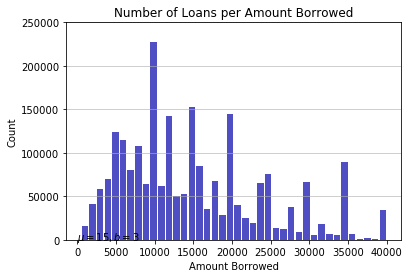

In [32]:

state_amt_brwd=df.select("addr_state","loan_amnt").toPandas()

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=state_amt_brwd.loan_amnt, bins=40, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Amount Borrowed')
plt.ylabel('Count')
plt.title('Number of Loans per Amount Borrowed')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=250000)

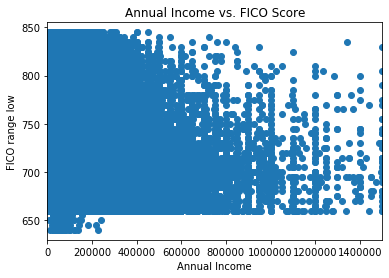

In [33]:
# create data
x = major_pred.annual_inc
y = major_pred.fico_range_low
 
plt.scatter(x, y)

plt.xlim(-1, 1500000)
plt.xlabel('Annual Income')
plt.ylabel('FICO range low')
plt.title('Annual Income vs. FICO Score' )
plt.show()

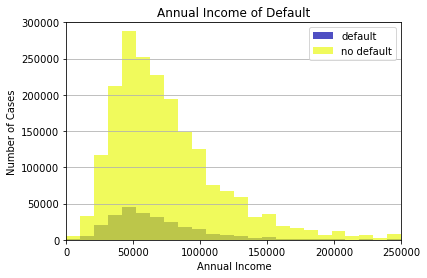

In [35]:
import numpy

bins = numpy.linspace(0, 250000, 25)

plt.hist(major_pred_default.annual_inc,bins, color='#0504aa', label="default",alpha=0.7)
plt.hist(major_pred_no_default.annual_inc,bins, color='#ebf917', label="no default",alpha=0.7)


plt.grid(axis='y', alpha=5)
plt.xlabel('Annual Income')
plt.ylabel('Number of Cases')
plt.title('Annual Income of Default' )
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=300000)
plt.xlim(xmin=0,xmax=250000)
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = [20,9]

plt.show()

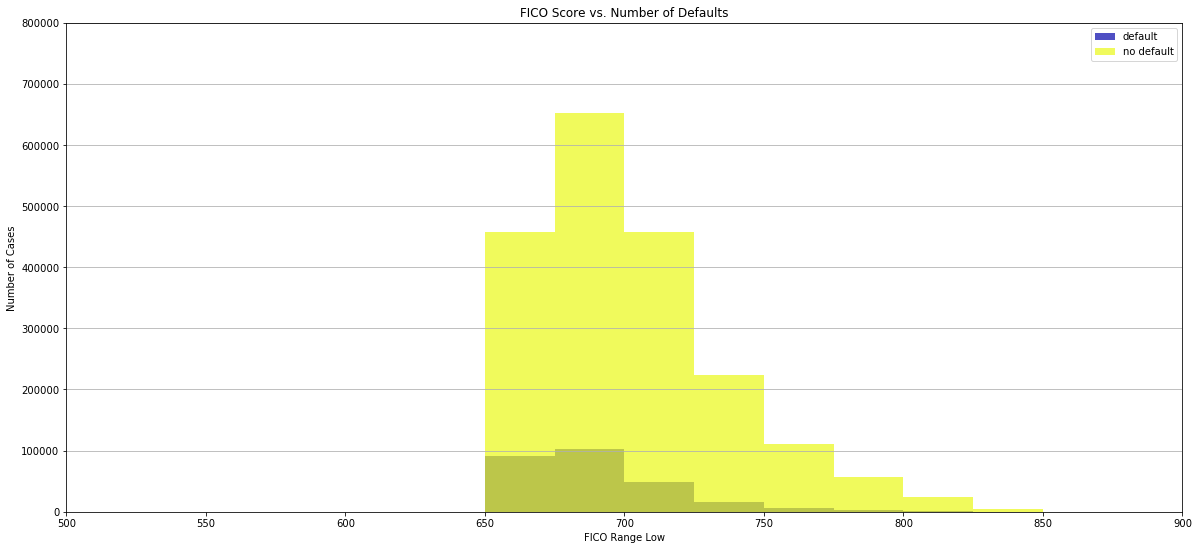

In [36]:
bins = numpy.linspace(300, 900, 25)

plt.hist(major_pred_default.fico_range_low,bins, color='#0504aa', label="default",alpha=0.7)
plt.hist(major_pred_no_default.fico_range_low,bins, color='#ebf917', label="no default",alpha=0.7)


plt.grid(axis='y', alpha=5)
plt.xlabel('FICO Range Low')
plt.ylabel('Number of Cases')
plt.title('FICO Score vs. Number of Defaults' )
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=800000)
plt.xlim(xmin=500,xmax=900)
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = [20,9]

plt.show()

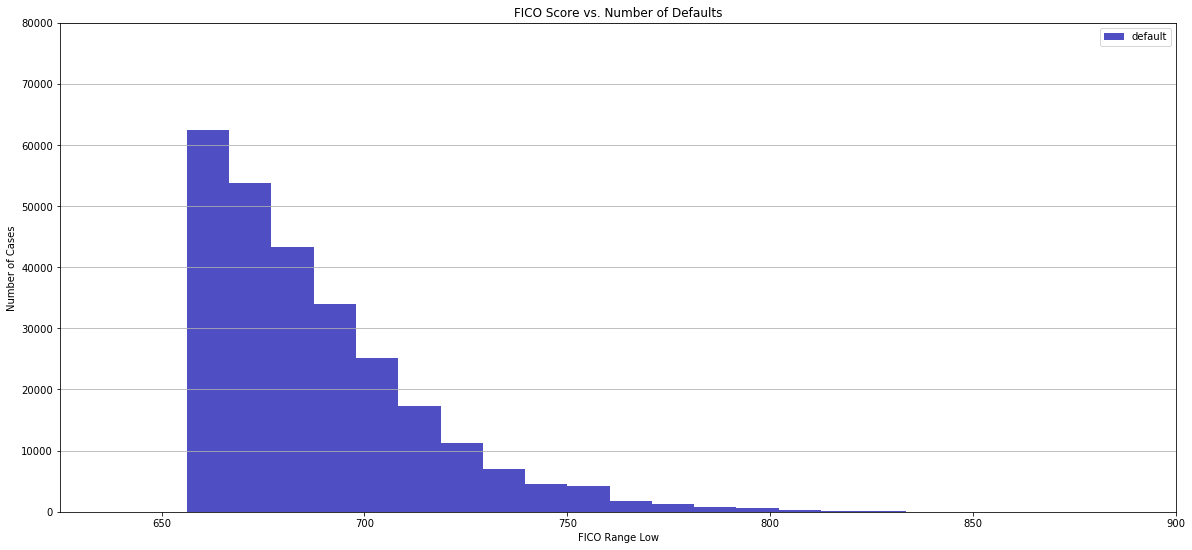

In [37]:
bins = numpy.linspace(625, 875, 25)

plt.hist(major_pred_default.fico_range_low,bins, color='#0504aa', label="default",alpha=0.7)
#plt.hist(major_pred_no_default.fico_range_low,bins, color='#ebf917', label="no default",alpha=0.7)


plt.grid(axis='y', alpha=5)
plt.xlabel('FICO Range Low')
plt.ylabel('Number of Cases')
plt.title('FICO Score vs. Number of Defaults' )
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=80000)
plt.xlim(xmin=625,xmax=900)
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = [20,9]

plt.show()

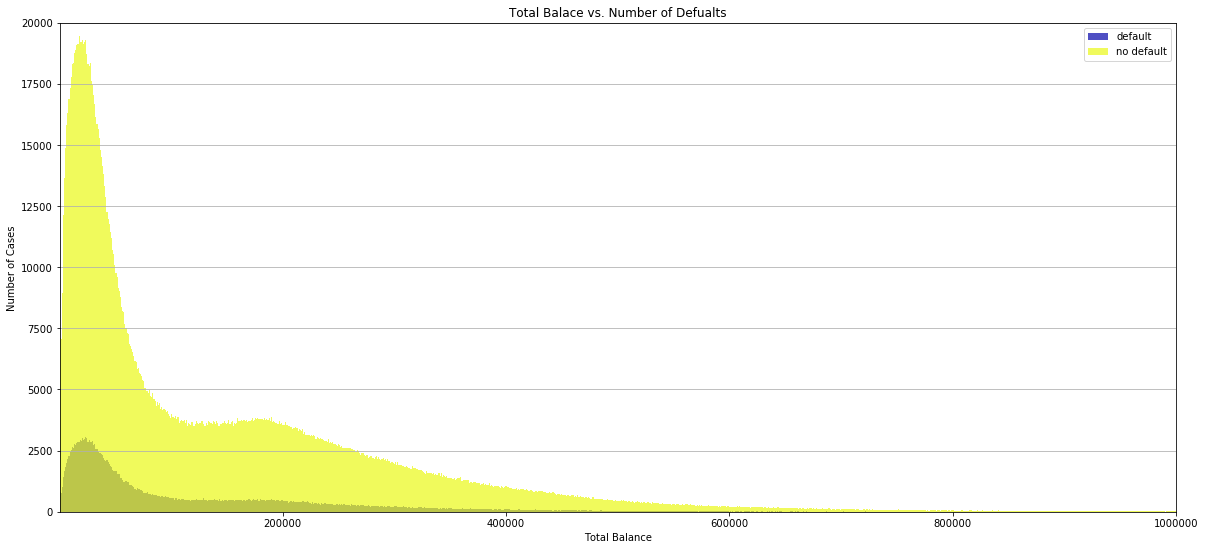

In [38]:
bins = numpy.linspace(0, 1000000, 1000)

plt.hist(major_pred_default.tot_cur_bal,bins, color='#0504aa', label="default",alpha=0.7)
plt.hist(major_pred_no_default.tot_cur_bal,bins, color='#ebf917', label="no default",alpha=0.7)


plt.grid(axis='y', alpha=5)
plt.xlabel('Total Balance')
plt.ylabel('Number of Cases')
plt.title('Total Balace vs. Number of Defualts' )
#plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
plt.ylim(ymax=20000)
plt.xlim(xmin=500,xmax=1000000)
plt.legend(loc='upper right')
plt.rcParams["figure.figsize"] = [20,9]

plt.show()